In [1]:
%autosave 600
%matplotlib inline

Autosaving every 600 seconds


In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import random
import os
import os.path
from glob import glob
from pathlib import Path
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import os
import time
import uuid
import cv2
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import model_from_json
from keras.layers import Flatten, Dense, BatchNormalization
from keras.models import Model
import keras
import keras.utils
from keras import utils as np_utils
from keras.applications.mobilenet import MobileNet, preprocess_input 
from keras.losses import categorical_crossentropy
from tensorflow.keras.utils import img_to_array, load_img
from keras.layers import Flatten, MaxPooling2D, Dropout
import tensorflow.keras as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam
from tensorflow.keras.applications.efficientnet import EfficientNetB2
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.layers.core import Dense, Activation, Lambda, Flatten
from keras.layers.pooling import MaxPooling2D, AveragePooling2D

## Limit GPU Memory Growth

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
# Making sure GPU is detected for computation
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Import Data and View, include image resizing and image augmentations

In [7]:
# Setting up validation dataframe
path = os.getcwd()
os.chdir(path)
file_list = []
file_name = []
arr_list = []
for filenames in os.walk('val_set/annotations'):
     for file in filenames[2]:
        if file.endswith('exp.npy'):
            # Load .npy file using numpy
            arr = (np.load('val_set/annotations/'+file).tolist())
            arr_list.append(arr)
            # Append the DataFrame to the main DataFrame
            file_name.append(file.replace('_exp.npy', ''))
            
file_list = dict(zip(file_name, arr_list),index=[0])
val_df = pd.DataFrame(file_list)
        
        
val_df = val_df.T
val_df = val_df.reset_index()
val_df = val_df.rename(columns={"index": "Image_Name", 0: "Expression"})
val_df.head(20)      

,Image_Name,Expression
0,0,0
1,1001,0
2,1002,4
3,1003,5
4,1007,2
5,1008,6
6,1009,3
7,100,3
8,1010,2
9,1011,4


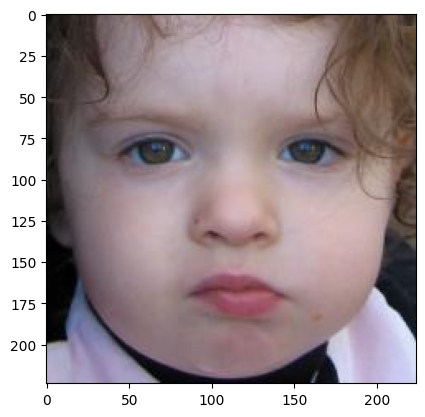

In [8]:
val_path= path+'/val_set/images'
os.chdir(val_path)
# Making sure images are properly formated
image = plt.imread(val_df['Image_Name'][0]+'.jpg')
plt.imshow(image)

In [9]:
# Setting up train dataframe
os.chdir(path)
file_list = []
file_name = []
arr_list = []
for filenames in os.walk('train_set/annotations'):
     for file in filenames[2]:
        if file.endswith('exp.npy'):
            # Load .npy file using numpy
            arr = (np.load('train_set/annotations/'+file).tolist())
            arr_list.append(arr)
            # Append the DataFrame to the main DataFrame
            file_name.append(file.replace('_exp.npy', ''))
            
file_list = dict(zip(file_name, arr_list),index=[0])
train_df = pd.DataFrame(file_list)
        
        
train_df = train_df.T
train_df = train_df.reset_index()
train_df = train_df.rename(columns={"index": "Image_Name", 0: "Expression"})
train_df.head(20)

,Image_Name,Expression
0,0,1
1,100000,1
2,100001,1
3,100002,0
4,100004,1
5,100006,6
6,100008,3
7,100009,4
8,100011,1
9,100012,7


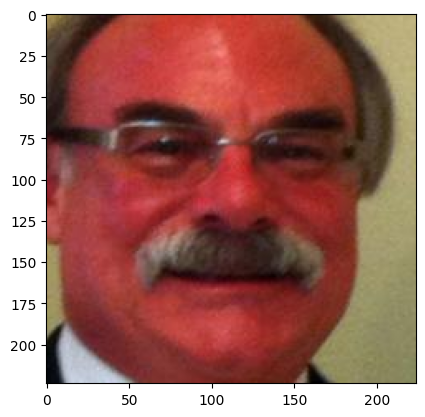

In [10]:
imageList = []
train_path = path+'/train_set/images'
os.chdir(train_path)
# Making sure images are properly formated
image = plt.imread(train_df['Image_Name'][0]+'.jpg')
plt.imshow(image)

In [11]:
val_df.drop(val_df.loc[val_df['Image_Name']=='index'].index, inplace=True)
train_df.drop(train_df.loc[train_df['Image_Name']=='index'].index, inplace=True)

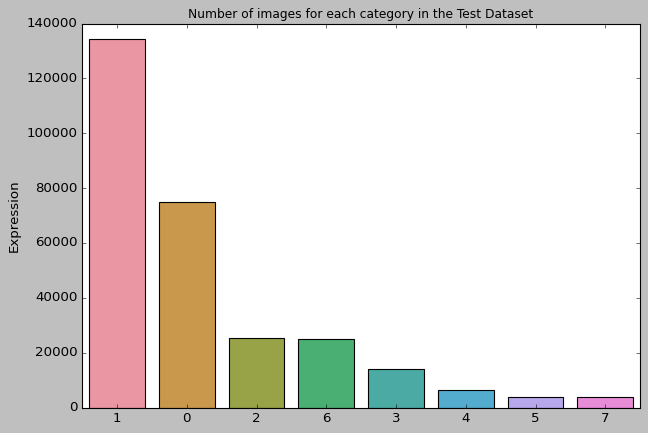

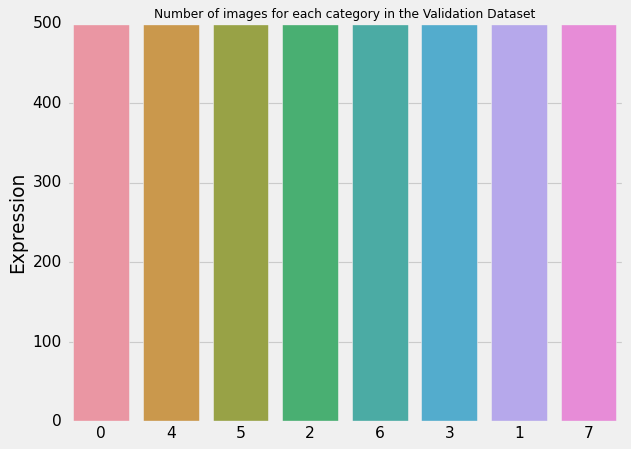

In [12]:
# Look at data volume
vc1 = train_df['Expression'].value_counts()
vc2 = val_df['Expression'].value_counts()
plt.style.use("classic")
plt.figure(figsize = (9,6))
sns.barplot(x = vc1.index, y = vc1)
plt.title("Number of images for each category in the Test Dataset", fontsize = 11)
plt.style.use('fivethirtyeight')
plt.figure(figsize = (8,6))
sns.barplot(x = vc2.index, y = vc2)
plt.title("Number of images for each category in the Validation Dataset", fontsize = 11)
plt.show()

In [13]:
train_path = path+'\\big_images\\train'
val_path = path+'\\big_images\\validation'

In [14]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                  width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   rotation_range = 20,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale= 1.0/255)

batch_size = 128

In [15]:
train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=(56,56),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(val_path,
                                                    target_size=(56,56),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 287651 images belonging to 8 classes.
Found 3999 images belonging to 8 classes.


In [16]:
# number of possible label values
nb_classes = 8

# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(56, 56, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation='softmax'))

print(model.summary())

opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 56, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 56, 56, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 56, 56, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 28, 28, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       2

In [18]:
%%time

# number of epochs to train the NN
epochs = 50

# checkpoint to save best model
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("big_model_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=train_generator.n//train_generator.batch_size,
                                epochs=epochs,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.n//validation_generator.batch_size,
                                callbacks=callbacks_list
                                )

<timed exec>:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50
2247/2247 [==============================] - ETA: 0s - loss: 1.4057 - accuracy: 0.5100
Epoch 1: val_accuracy improved from -inf to 0.25605, saving model to big_model_weights.h5
2247/2247 [==============================] - 976s 433ms/step - loss: 1.4057 - accuracy: 0.5100 - val_loss: 2.2736 - val_accuracy: 0.2560
Epoch 2/50
2247/2247 [==============================] - ETA: 0s - loss: 1.1110 - accuracy: 0.6161
Epoch 2: val_accuracy improved from 0.25605 to 0.30620, saving model to big_model_weights.h5
2247/2247 [==============================] - 294s 131ms/step - loss: 1.1110 - accuracy: 0.6161 - val_loss: 2.1689 - val_accuracy: 0.3062
Epoch 3/50
2247/2247 [==============================] - ETA: 0s - loss: 1.0092 - accuracy: 0.6487
Epoch 3: val_accuracy improved from 0.30620 to 0.33443, saving model to big_model_weights.h5
2247/2247 [==============================] - 290s 129ms/step - loss: 1.0092 - accuracy: 0.6487 - val_loss: 1.9817 - val_accuracy: 0.3344
Epoch 4/50
2247/224

In [62]:
# Saving model for use in other notebooks
os.chdir(path)
model.save('saved_model/big_model_weights.json')

In [20]:
# Visualise training and testing accuracy and loss

def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize = (24, 6))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', label = 'Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    


    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()
 
# Print best epoch with best accuracy on validation

def get_best_epcoh(history):
    valid_acc = history.history['val_accuracy']
    best_epoch = valid_acc.index(max(valid_acc)) + 1
    best_acc =  max(valid_acc)
    print('Best Validation Accuracy Score {:0.5f}, is for epoch {}'.format( best_acc, best_epoch))
    return best_epoch

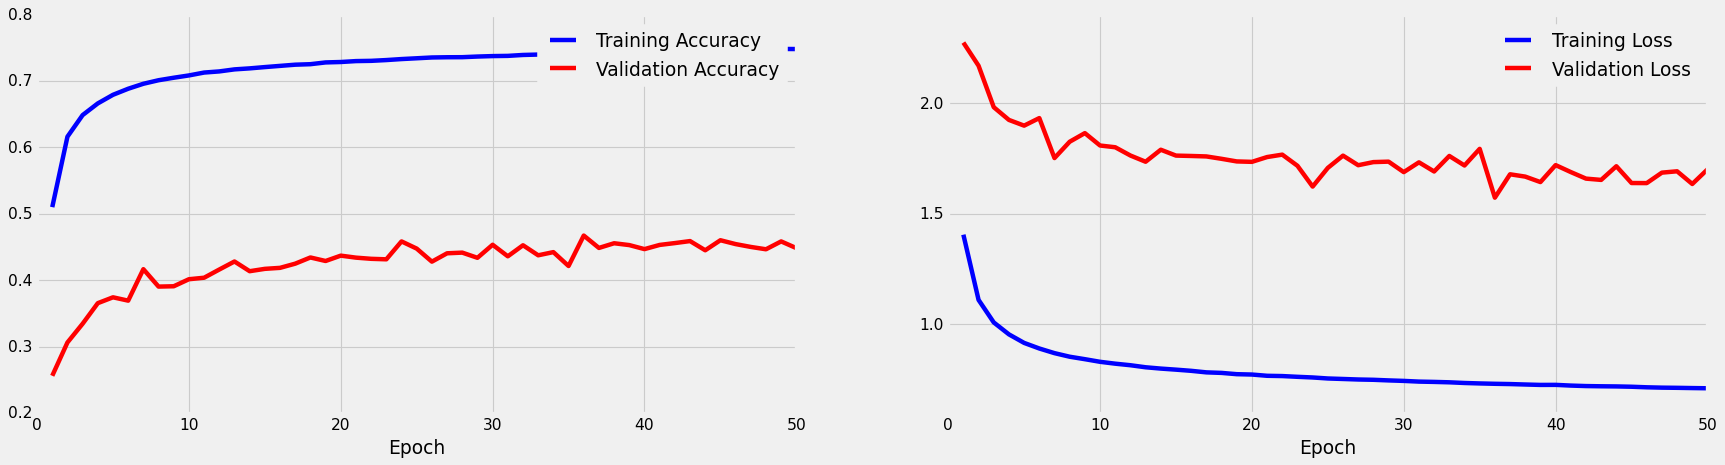

Best Validation Accuracy Score 0.46724, is for epoch 36


In [21]:
plot_results(history)
best_epoch =get_best_epcoh(history)

In [64]:
model_in_json = model.to_json()
with open('saved_model\\big_model.json','w') as json_file:
    json_file.write(model_in_json)

In [66]:
# Saving model and weights for use in other notebooks
model_json_file = 'saved_model\\big_model.json'
model_weights_file = 'saved_model\\big_model_weights.h5'
with open(model_json_file, "r") as json_file:
    loaded_model_json = json_file.read()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(model_weights_file)